In [ ]:
#default_exp byol

# BYOL

> Bootstrap Your Own Latent A New Approach to Self-Supervised Learning

Paper Link: https://arxiv.org/pdf/2006.07733.pdf

In [ ]:
#export
from fastai.vision.all import *
import kornia
import copy

## Data Augmentation

In [ ]:
#export
def get_aug_pipe(size, stats=imagenet_stats, s=.6, color=True, xtra_tfms=[]):
    "SimCLR augmentations"
    tfms = []
    tfms += [kornia.augmentation.RandomResizedCrop((size, size), scale=(0.2, 1.0), ratio=(3/4, 4/3))]
    tfms += [kornia.augmentation.RandomHorizontalFlip()]
    
    if color: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if color: tfms += [kornia.augmentation.RandomGrayscale(p=0.2)]    
    if stats is not None: tfms += [Normalize.from_stats(*stats)]
    
    tfms += xtra_tfms
    
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

In [ ]:
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

In [ ]:
aug = get_aug_pipe(224)
x = aug(t)
assert x.shape[-2:] == torch.Size([224,224])

Default SimCLR augmentations

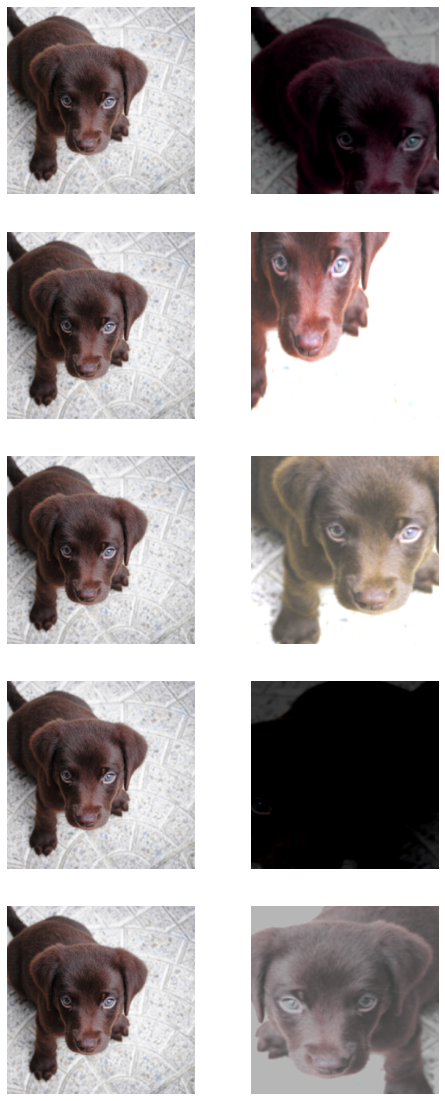

In [ ]:
aug = get_aug_pipe(224)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

Default SimCLR augmentations with extra transforms

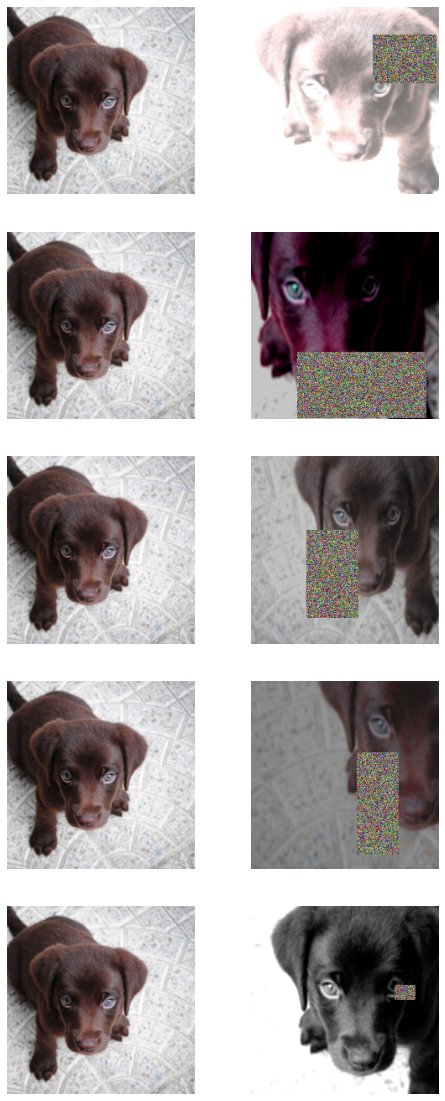

In [ ]:
aug = get_aug_pipe(224, xtra_tfms=[RandomErasing(p=1.)])
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

In [ ]:
#export
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

In [ ]:
encoder = create_encoder(resnet18, n_in=3, pretrained=False, cut=None, concat_pool=True)
assert isinstance(encoder[-2], AdaptiveConcatPool2d)
assert isinstance(encoder[-1], Flatten)
representation = encoder(x)
assert representation.shape == torch.Size([1,1024])

In [ ]:
encoder = create_encoder(resnet50, n_in=1, pretrained=True, cut=None, concat_pool=False)
assert isinstance(encoder[-2], nn.AdaptiveAvgPool2d)
assert isinstance(encoder[-1], Flatten)
_x = torch.randn((1,1,224,224))
representation = encoder(_x)
assert representation.shape == torch.Size([1,2048])

In [ ]:
#export
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, projection_size=256, hidden_size=2048):
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#export
class BYOLModel(Module):
    "Compute predictions of v1 and v2" 
    def __init__(self,encoder,projector,predictor):
        self.encoder,self.projector,self.predictor = encoder,projector,predictor    

    def forward(self,v1,v2):
        q1 = self.predictor(self.projector(self.encoder(v1)))
        q2 = self.predictor(self.projector(self.encoder(v2)))
        return (q1,q2)

In [ ]:
#export
def create_byol_model(arch=resnet50, n_in=3, pretrained=True, cut=None, concat_pool=True,
                      hidden_size=4096, projection_size=256):
    encoder = create_encoder(arch, n_in, pretrained, cut, concat_pool)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = MLP(representation.size(1), projection_size, hidden_size=hidden_size)     
    predictor = MLP(projection_size, projection_size, hidden_size=hidden_size)
    apply_init(projector)
    apply_init(predictor)
    return BYOLModel(encoder, projector, predictor)

In [ ]:
model = create_byol_model(resnet18)
v1,v2 = aug(t), aug(t)
assert not torch.equal(v1,v2)
q1,q2 = model(torch.cat([v1,v2]),torch.cat([v2,v1])) # min 2 inputs - batchnorm
assert torch.equal(q1.flipud(),q2)

In [ ]:
#export
def cosine_similarity(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    return torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)

In [ ]:
cosine_similarity(q1, q2)

tensor([[0.0356, 1.0000],
        [1.0000, 0.0356]], grad_fn=<DivBackward0>)

In [ ]:
#export
def _mse_loss(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

def symmetric_mse_loss(pred, *yb):
    (q1,q2),z1,z2 = pred,*yb
    return (_mse_loss(q1,z2) + _mse_loss(q2,z1)).mean()
byol_loss = symmetric_mse_loss

## BYOLCallback

In [ ]:
#export
class BYOL(Callback):
    "Implementation of https://arxiv.org/pdf/2006.07733.pdf"
    def __init__(self, T=0.99, debug=True, size=224, **aug_kwargs):        
        self.T, self.debug = T, debug
        self.aug1 = get_aug_pipe(size, **aug_kwargs)
        self.aug2 = get_aug_pipe(size, **aug_kwargs)


    def before_fit(self):
        "Create target model"
        self.target_model = copy.deepcopy(self.learn.model).to(self.dls.device)        
        self.T_sched = SchedCos(self.T, 1) 
  
        
    def before_batch(self):
        "Generate 2 views of the same image and calculate target projections for these views"
        if self.debug: print(f"self.x[0]: {self.x[0]}")
        
        v1,v2 = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (v1,v2)
        
        if self.debug:
            print(f"v1[0]: {v1[0]}\nv2[0]: {v2[0]}")
            self.show_one()
            assert not torch.equal(*self.learn.xb)

        with torch.no_grad():
            z1 = self.target_model.projector(self.target_model.encoder(v1))
            z2 = self.target_model.projector(self.target_model.encoder(v2))
            self.learn.yb = (z1,z2)


    def after_step(self):
        "Update target model and T"
        self.T = self.T_sched(self.pct_train)
        with torch.no_grad():
            for param_k, param_q in zip(self.target_model.parameters(), self.model.parameters()):
                param_k.data = param_k.data * self.T + param_q.data * (1. - self.T)
          

    def show_one(self):
        b1 = self.aug1.decode(to_detach(self.learn.xb[0]))
        b2 = self.aug2.decode(to_detach(self.learn.xb[1]))
        i = np.random.choice(len(b1))
        show_images([b1[i],b2[i]], nrows=1, ncols=2)        

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=2, after_item=[ToTensor(), IntToFloatTensor()])


In [ ]:
model = create_byol_model(arch=resnet18, n_in=1, pretrained=False)
learn = Learner(dls, model, byol_loss,
                cbs=[BYOL(T=0.99, size=28, debug=False, color=False, stats=None),
                     ShortEpochCallback(0.001)])

In [ ]:
learn.fit(1)

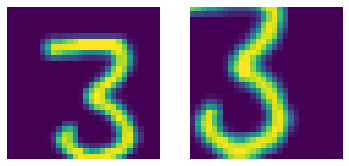

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.byol.show_one()

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 10-byol.ipynb.
